In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parents[1]
sys.path.append(str(project_root))

In [42]:
import re

import pandas as pd

In [ ]:


PLDDT_PATH = project_root / "data" / "pockets_mean_plddt.csv"
RMSD_PATH = project_root / "pockets_rmsd_batch_1.csv"

plddt_data = pd.read_csv(PLDDT_PATH)
rmsd_data = pd.read_csv(RMSD_PATH)

In [18]:
all_data = pd.merge(
    plddt_data,
    rmsd_data,
    on="alphafold_pocket_selection",
    how="inner",
    suffixes=("_plddt", "_rmsd"),
)

In [26]:
all_data.head()

,uniprot_id_plddt,alphafold_pocket_selection,mean_plddt,pdb_id,query_poi,chain,uniprot_id_rmsd,pdb_pocket_selection,pocket_rmsd,missing_holo_residues,missing_apo_residues
0,Q8IL11,AF-Q8IL11-F1-model_v4 and ( resi 374+379+386+3...,98.145500,3kr4,K_BES_1003,K,Q8IL11,3kr4 and ( (chain K and resi 374+379+386+392+3...,0.122312,NaN,NaN
1,Q8IL11,AF-Q8IL11-F1-model_v4 and ( resi 374+379+386+3...,98.145500,3kr4,L_BES_1003,L,Q8IL11,3kr4 and ( (chain L and resi 374+379+386+392+3...,0.153370,NaN,NaN
2,Q9NAV8,AF-Q9NAV8-F1-model_v4 and ( resi 25+32+35+36+3...,96.951364,3kun,B_HEM_139,B,Q9NAV8,3kun and ( (chain B and resi 24+31+34+35+36+51...,0.528742,NaN,NaN
3,Q9NAV8,AF-Q9NAV8-F1-model_v4 and ( resi 25+32+35+36+3...,96.951364,3kuo,B_HEM_139,B,Q9NAV8,3kuo and ( (chain B and resi 24+31+34+35+36+51...,0.559556,NaN,NaN
4,B3TMQ9,AF-B3TMQ9-F1-model_v4 and ( resi 72+76+78+80+9...,97.025217,5t67,A_SAH_502,A,B3TMQ9,5t67 and ( (chain A and resi 72+76+78+80+90+11...,0.190600,NaN,NaN


<Axes: >

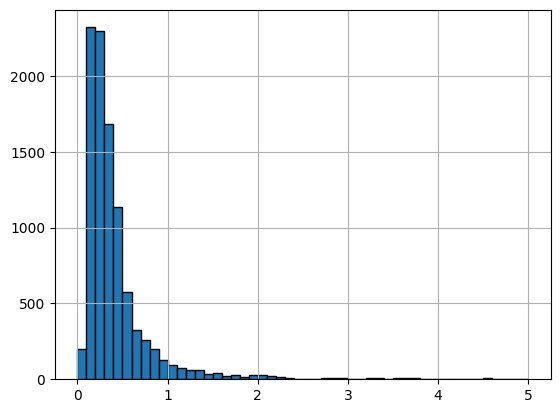

In [24]:
all_data['pocket_rmsd'].hist(bins=50, range=(0, 5), edgecolor='black')

<Axes: >

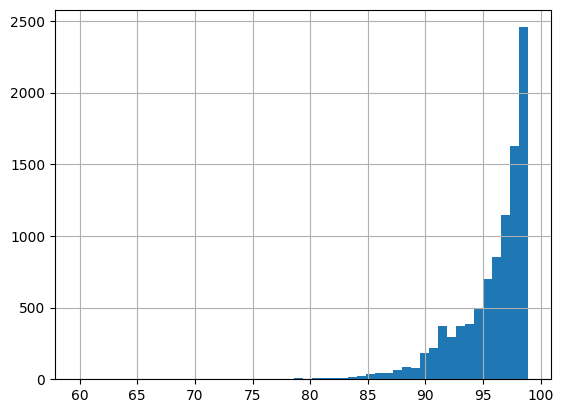

In [28]:
all_data[all_data['pocket_rmsd'] < 2.0]['mean_plddt'].hist(bins=50)

<Axes: >

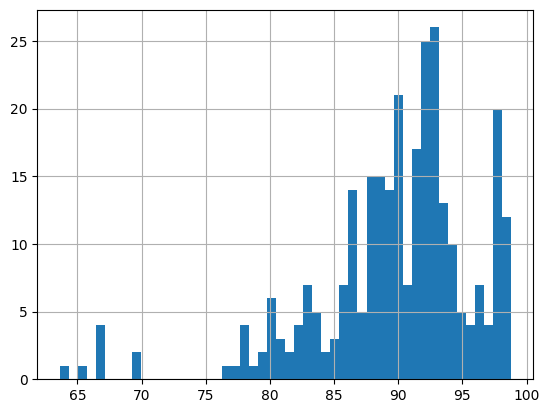

In [31]:
all_data[all_data['pocket_rmsd'] >= 2.0]['mean_plddt'].hist(bins=50)

In [25]:
(all_data['pocket_rmsd'] > 2).sum()

np.int64(290)

## Convert to CryptoBench format

In [51]:
def parse_pocket_selection(
    selection: str,
    default_chain: str = "A",
) -> tuple[str, list[int]]:
    """
    Parse a PyMOL selection string to extract chain ID and residue indices.
    """
    chain_match = re.search(r'chain\s+([A-Za-z])', selection)
    chain_id = chain_match.group(1) if chain_match else default_chain

    resi_match = re.search(r'resi\s+([0-9+\s]+)', selection)
    if not resi_match:
        raise ValueError("No residue information found in selection string.")

    resi_list = [int(r.strip()) for r in resi_match.group(1).split('+') if r.strip().isdigit()]

    return chain_id, resi_list


def parse_ligand_id(query_poi: str) -> tuple[str, str, str]:
    """
    Parse ligand infor string formatted as {ligand_chain}_{ligand}_{ligand_index}
    """
    parts = query_poi.split('_')
    if len(parts) != 3:
        raise ValueError("Ligand information must be in the format 'chain_ligand_index'.")

    ligand_chain, ligand, ligand_index = parts
    return ligand_chain, ligand, ligand_index


def parse_pocket_data(row):
    apo_structure_name = row['alphafold_pocket_selection'].split(' ')[0]

    uniprot_id = row['uniprot_id_rmsd']
    holo_pdb_id = row['pdb_id']
    holo_chain = row['chain']
    apo_chain = "A" # AlphaFold structures have only one chain

    ligand_chain, ligand, ligand_index = parse_ligand_id(row['query_poi'])

    apo_pymol_selection = row['alphafold_pocket_selection']
    holo_pymol_selection = row['pdb_pocket_selection']

    apo_pocket_chain, apo_pocket_residues = parse_pocket_selection(apo_pymol_selection, default_chain=apo_chain)
    holo_pocket_chain, holo_pocket_residues = parse_pocket_selection(holo_pymol_selection, default_chain=holo_chain)

    apo_pocket_selection = [
        apo_pocket_chain + "_" + str(residue) for residue in apo_pocket_residues
    ]
    holo_pocket_selection = [
        holo_pocket_chain + "_" + str(residue) for residue in holo_pocket_residues
    ]

    pRMSD = row['pocket_rmsd']
    is_main_holo_structure = False

    pocket_data = {
        "uniprot_id": uniprot_id,
        "holo_pdb_id": holo_pdb_id,
        "holo_chain": holo_chain,
        "apo_chain": apo_chain,
        "ligand_chain": ligand_chain,
        "ligand": ligand,
        "ligand_index": ligand_index,
        "apo_pocket_selection": apo_pocket_selection,
        "holo_pocket_selection": holo_pocket_selection,
        "pRMSD": pRMSD,
        "is_main_holo_structure": is_main_holo_structure
    }

    return apo_structure_name, pocket_data


In [57]:
alphafold_train_data = {}

for _, row in all_data[:10000].iterrows():
    # Crypticity cryterion
    if row['pocket_rmsd'] < 2.0 or pd.isna(row['pocket_rmsd']):
        continue

    apo_structure_name, pocket_data = parse_pocket_data(row)

    print(
        f"{apo_structure_name}, "
        f"{row['mean_plddt']:.2f}, "
        f"{row['pocket_rmsd']:.2f} > 2.0"
    )

    if apo_structure_name not in alphafold_train_data:
        alphafold_train_data[apo_structure_name] = []
    alphafold_train_data[apo_structure_name].append(pocket_data)

AF-P80025-F1-model_v4, 91.96, 3.38 > 2.0
AF-P00183-F1-model_v4, 98.27, 4.30 > 2.0
AF-P00183-F1-model_v4, 98.17, 4.51 > 2.0
AF-Q7BNC2-F1-model_v4, 97.37, 3.10 > 2.0
AF-P24474-F1-model_v4, 91.95, 3.15 > 2.0
AF-E4N8S5-F1-model_v4, 83.51, 2.85 > 2.0
AF-E4N8S5-F1-model_v4, 83.51, 2.91 > 2.0
AF-O13836-F1-model_v4, 91.88, 2.11 > 2.0
AF-O13836-F1-model_v4, 92.38, 2.09 > 2.0
AF-Q2MHR1-F1-model_v4, 77.95, 3.13 > 2.0
AF-P77150-F1-model_v4, 94.25, 2.37 > 2.0
AF-P77150-F1-model_v4, 92.57, 3.23 > 2.0
AF-P0A9P4-F1-model_v4, 96.26, 3.34 > 2.0
AF-P93836-F1-model_v4, 88.88, 2.01 > 2.0
AF-Q9FCA6-F1-model_v4, 86.32, 2.03 > 2.0
AF-P0A9P4-F1-model_v4, 96.27, 3.97 > 2.0
AF-P0A9P4-F1-model_v4, 95.48, 3.69 > 2.0
AF-A0A0G9F7S9-F1-model_v4, 97.61, 2.25 > 2.0
AF-A0A0G9F7S9-F1-model_v4, 97.61, 2.22 > 2.0
AF-P93836-F1-model_v4, 88.65, 2.23 > 2.0
AF-A0A0G9F7S9-F1-model_v4, 97.56, 2.27 > 2.0
AF-A0A0G9F7S9-F1-model_v4, 97.58, 2.13 > 2.0
AF-O50260-F1-model_v4, 89.16, 2.75 > 2.0
AF-Q8GGK7-F1-model_v4, 92.71, 2.04 > 2.0


In [53]:
alphafold_train_data

{'AF-P80025-F1-model_v4': [{'uniprot_id': 'P80025',
   'holo_pdb_id': '3krq',
   'holo_chain': 'A',
   'apo_chain': 'A',
   'ligand_chain': 'A',
   'ligand': '3TR',
   'ligand_index': '608',
   'apo_pocket_selection': ['A_371', 'A_372', 'A_375', 'A_498', 'A_541'],
   'holo_pocket_selection': ['A_254', 'A_255', 'A_258', 'A_381', 'A_424'],
   'pRMSD': 3.3814532979555953,
   'is_main_holo_structure': False}],
 'AF-P00183-F1-model_v4': [{'uniprot_id': 'P00183',
   'holo_pdb_id': '6nbl',
   'holo_chain': 'B',
   'apo_chain': 'A',
   'ligand_chain': 'B',
   'ligand': 'CAM',
   'ligand_index': '503',
   'apo_pocket_selection': ['A_90',
    'A_95',
    'A_97',
    'A_98',
    'A_249',
    'A_252',
    'A_298',
    'A_397'],
   'holo_pocket_selection': ['B_89',
    'B_94',
    'B_96',
    'B_97',
    'B_248',
    'B_251',
    'B_297',
    'B_396'],
   'pRMSD': 4.298252205823446,
   'is_main_holo_structure': False},
  {'uniprot_id': 'P00183',
   'holo_pdb_id': '6nbl',
   'holo_chain': 'A',
   'a

In [55]:
# Save to JSON
import json
output_file = project_root / "data" / "alphafold_pockets_train_data.json"
with open(output_file, 'w') as f:
    json.dump(alphafold_train_data, f, indent=4)
print(f"Data saved to {output_file}")

Data saved to /Users/pawel/deeplife-binding-sites/data/alphafold_pockets_train_data.json
